# Are we consuming more local?

## Research questions

1. Where are the products we consume in our everyday life coming from?

    - Which countries produce the primary resources (ground ingredients) consumed in Switzerland?
    - Which countries manufacture most of the products consumed in Switzerland?


2. Is there a trend over time to consume more local products?

    - Are new products mostly using primary resources from Switzerland? Or from other countries inside Europe?
    - Are new products mostly manufactured in Switzerland? Or from other countries inside Europe?
    - Is there a trend over time to local products to promote their origin?

## Datasets

Open Food Facts (https://world.openfoodfacts.org/data)

Additional datasets “Evolution de la consommation de denrées alimentaires en Suisse” (https://opendata.swiss/fr/dataset/entwicklung-des-nahrungsmittelverbrauches-in-der-schweiz-je-kopf-und-jahr1) and “Dépenses fédérales pour l’agriculture et l’alimentation” (https://opendata.swiss/fr/dataset/bundesausgaben-fur-die-landwirtschaft-und-die-ernahrung1) from https://opendata.swiss/fr/group/agriculture

A last additional dataset for the second question of the project
https://www.gate.ezv.admin.ch/swissimpex/public/bereiche/waren/result.xhtml
Total of imports of agriculture, forestry and fishing goods


In [2]:
#imports
import re
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

import findspark
findspark.init()
import pyspark

from functools import reduce
from pyspark.sql import *
from pyspark.sql import functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import *
from pyspark.sql.functions import min
from pyspark.sql.functions import to_date, last_day,date_add
from datetime import timedelta

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [3]:
DATA_FOLDER = 'data'

# Loading data

## Open Food Fact data

General information about columns of OpenFoodFact dataset are available on:

https://static.openfoodfacts.org/data/data-fields.txt

__General information__
- __code__: barcode of the product (can be EAN-13 or internal codes for some food stores), for products without a barcode, Open Food Facts assigns a number starting with the 200 reserved prefix
- __product_name__: name of the product

__Geo information__
- __origins__: origins of ingredients
- __manufacturing_places__: places where manufactured or transformed
- __countries__: list of countries where the product is sold


In [4]:
dataset_main = spark.read.csv(DATA_FOLDER+"/en.openfoodfacts.org.products.csv", header=True, mode="DROPMALFORMED", sep = '\t')

dataset_main.createOrReplaceTempView("data_main")

# Filter required columns
p_id_col = " code, product_name, "
general_cols = " brands, brands_tags, categories, categories_tags, origins, origins_tags, manufacturing_places, manufacturing_places_tags,labels,labels_tags,emb_codes,emb_codes_tags,first_packaging_code_geo,cities,cities_tags,purchase_places,stores,countries,countries_tags "
geo_cols = " origins, manufacturing_places, countries "
geo_tags_cols = " origins_tags, manufacturing_places_tags, countries_tags "

off_df = spark.sql("SELECT" + p_id_col + geo_cols + " FROM data_main")
off_df.printSchema()

root
 |-- code: string (nullable = true)
 |-- product_name: string (nullable = true)
 |-- origins: string (nullable = true)
 |-- manufacturing_places: string (nullable = true)
 |-- countries: string (nullable = true)



In [5]:
off_all_size = off_df.count()
off_cols_size = len(off_df.columns)
print("All data Size:\n" + str(off_cols_size) + "(columns) * " + str(off_all_size) + "(rows)")

All data Size:
5(columns) * 693829(rows)


### Data Cleaning and Preprocessing

In [41]:
# Find number of missing data

off_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in off_df.columns]).show()

+----+------------+-------+--------------------+---------+
|code|product_name|origins|manufacturing_places|countries|
+----+------------+-------+--------------------+---------+
|   0|       25982| 651635|              626848|      561|
+----+------------+-------+--------------------+---------+



In [6]:
off_df.createOrReplaceTempView("off_df")

sql_filter = "SELECT * FROM off_df WHERE countries is not NULL AND manufacturing_places is not NULL AND origins is not NULL"

off_p_df = spark.sql(sql_filter)
off_p_all_size = off_p_df.count()
off_p_cols_size = len(off_p_df.columns)
print("Full GEO information data Size:\n" + str(off_p_cols_size) + "(columns) * " + str(off_p_all_size) + "(rows)")

Full GEO information data Size:
5(columns) * 26986(rows)


In [44]:
off_p_df.show(10)

+-------------+--------------------+-------------+--------------------+--------------+
|         code|        product_name|      origins|manufacturing_places|     countries|
+-------------+--------------------+-------------+--------------------+--------------+
|0000000274722|Blanquette de Vol...|       France|              France|        France|
|0000000290616|        Salade Cesar|       Québec|     Brossard Québec|        Canada|
|0000000394710|Danoises à la can...|       Québec|     Brossard Québec|        Canada|
|0000001071894|               Flute|       France|      United Kingdom|United Kingdom|
|0000001938067|Chaussons tressés...|       Québec|     Brossard Québec|        Canada|
|0000004302544| Pain Burger Artisan|       Québec|     Brossard,Québec|        Canada|
|0000008237798|     Quiche Lorraine|       Québec|     Brossard,Québec|        Canada|
|0000008240095|      Pâté au poulet|       Québec|     Brossard Québec|        Canada|
|0000012167005|Brioches roulées ...|Québec,

We should determine the list of products that are sold in Switzerland

In [7]:
# create a specific filter for Swiss occurences

filter_ch = '[Ss]witzerland|[Ss]uisse|[Ss]chweiz|[Ss]vizerra'

In [8]:
# store products that are sold in Switzerland
swiss_sold_data = off_p_df.filter(off_p_df["countries"].rlike(filter_ch))

swiss_sold_size = swiss_sold_data.count()
print("swiss_sold data Size:\n" + str(swiss_sold_size))

swiss_sold data Size:
762


From now we work on products sold in Switzerland. 
We classify these products under different categories:
- products manufactured in Switzerland
- products not manufactured Switzerland to find which countries manufacture the most products consumed in Switzerland.
- products not originating from Switzerland to find which countries produce the ground ingredients for products sold in Switzerland.

In [50]:
# store products which ingredients originate from Switzerland
swiss_origin_data = off_p_df.filter(off_p_df["origins"].rlike(filter_ch))

swiss_origin_size = swiss_origin_data.count()
print("swiss_origin data Size:\n" + str(swiss_origin_size))

swiss_origin data Size:
482


In [51]:
# store products that are manufactured in Switzerland
swiss_manu_data = off_p_df.filter(off_p_df["manufacturing_places"].rlike(filter_ch))

swiss_manu_size = swiss_manu_data.count()
print("swiss_manufactored data Size:\n" + str(swiss_manu_size))

swiss_manufactored data Size:
545


In [52]:
# store products that are both manufactured and originate from Switzerland
swiss_origin_manu_data = off_p_df.filter(off_p_df["origins"].rlike(filter_ch) & off_p_df["manufacturing_places"].rlike(filter_ch))

swiss_origin_manu_size = swiss_origin_manu_data.count()
print("swiss_origin_manufactored data Size:\n" + str(swiss_origin_manu_size))

swiss_origin_manufactored data Size:
379


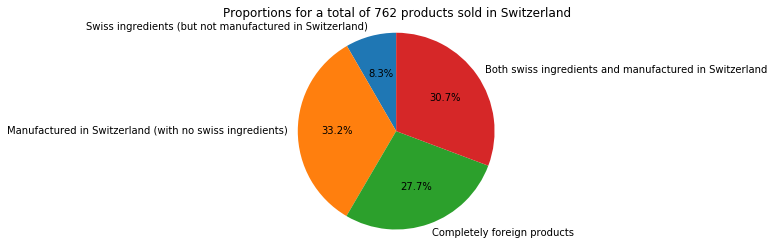

In [173]:
#count products whose ingredients from switzerland but which were not manufactured in Switzerland
swiss_origin_tot = swiss_origin_data.filter(~ swiss_origin_data["manufacturing_places"].rlike(filter_ch)).count()

#Total of products sold in Switzerland
swiss_sold_tot = swiss_sold_data.count()

#count products that do not have swiss ingredients
swiss_manu_tot = swiss_manu_data.filter(~ swiss_manu_data["origins"].rlike(filter_ch)).count()

#products that are sold in Switzerland but that were not manufactured in CH and that do not have swiss ingredients
non_swiss_sold_tot = swiss_sold_data.filter(~ swiss_sold_data["manufacturing_places"].rlike(filter_ch) & ~swiss_sold_data["origins"].rlike(filter_ch)).count()

#total of products that are both manufactured and has ingredients from Switzerland
swiss_origin_manu_tot = swiss_origin_manu_data.count()

labels = 'Swiss ingredients (but not manufactured in Switzerland)', 'Manufactured in Switzerland (with no swiss ingredients)', 'Completely foreign products', 'Both swiss ingredients and manufactured in Switzerland'
sizes = [swiss_origin_tot, swiss_manu_tot, non_swiss_sold_tot, swiss_origin_manu_tot]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Proportions for a total of ' + str(swiss_sold_tot) + ' products sold in Switzerland')

plt.show()

According to above chart, we can see that Switzerland tend to use local ingredients to manufacture products. Since most of products manufactured in Switzerland are produced by mostly Swiss ingredients.

In [9]:
#Store products that are not manufactured in Switzerland
non_swiss_sold = swiss_sold_data.filter(~swiss_sold_data["manufacturing_places"].rlike(filter_ch))

non_swiss_sold_size = non_swiss_sold.count()
print("Non swiss/Sold in Switzerland data Size:\n" + str(non_swiss_sold_size))

Non swiss/Sold in Switzerland data Size:
373


In [168]:
#Store products that are manufactured in Switzerland
swiss_m_sold = swiss_sold_data.filter(swiss_sold_data["manufacturing_places"].rlike(filter_ch))

swiss_m_sold_size = swiss_m_sold.count()
print("Swiss/Sold in Switzerland data Size:\n" + str(swiss_m_sold_size))

Swiss/Sold in Switzerland data Size:
389


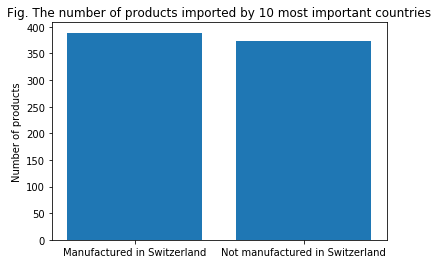

In [171]:
# Plot the number Swiss vs non-swiss products (Manufacturing)
fig, ax = plt.subplots()
titles = ['Manufactured in Switzerland', 'Not manufactured in Switzerland']
plt.bar(titles, [swiss_m_sold_size, non_swiss_sold_size])
plt.ylabel('Number of products')   
plt.xticks(titles)
plt.title('Fig. The number of products imported by 10 most important countries')
plt.show()

Out of __762__ products sold in Switzerland, Just about __51%__ of them was manufactured in Switzerland.

The dataset is not concistent with the country or places name, therefore, we have to clean the data by trying to unify a maximum the places names. First the database http://download.geonames.org/export/dump/ was used in order to match all the different ways of naming a country to a single convention but since there are some rows which need human intelligence to process(for example some fields contain name of ingredient or details) in the end we prefered to clean data manually. 

In [129]:
cleaned_countries = pd.read_csv("cleaning_data/origins_cleaning.csv")

# Clean origins countries

for index, row in cleaned_countries[::-1].iterrows():
    if(str(row['replace_with']) != "nan"):
        non_swiss_sold = non_swiss_sold.withColumn('origins', F.regexp_replace('origins', row['origins'], row['replace_with']))
    else:
        non_swiss_sold = non_swiss_sold.withColumn('origins', F.regexp_replace('origins', row['origins'], ""))

    

In [155]:
# Find dominant importers of ingredients

# Flatten origins column
origins_p = non_swiss_sold.withColumn('origins', F.explode_outer(F.split('origins', ',')))
origins_p.createOrReplaceTempView("origins_p")
target_origins = spark.sql("SELECT origins, COUNT(origins) FROM origins_p GROUP BY origins ORDER BY COUNT(origins) DESC")
target_origins = target_origins.withColumnRenamed('count(origins)' , 'Count')

print("Number of ingredient importers:\n" + str(target_origins.count()))

Number of ingredient importers:
80


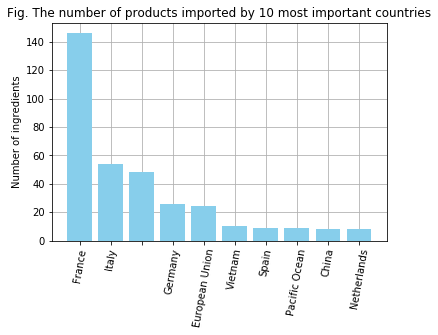

In [156]:
# Extract the 10 most important countries and number of occurances in ingredients.
origin_countries = target_origins.toPandas() 
origin_countries = origin_countries.head(10)

# Plot the number of products imported by 10 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(origin_countries.origins, origin_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(origin_countries.origins, rotation='80')
plt.title('Fig. The number of products imported by 10 most important countries')
plt.show()

In [119]:
# Export origins to CSV 
target_origins.select("origins").toPandas().to_csv('output/origins.csv')

In [150]:
# Clean manufacturers countries

for index, row in cleaned_countries[::-1].iterrows():
    if(str(row['replace_with']) != "nan"):
        non_swiss_sold = non_swiss_sold.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', row['origins'], row['replace_with']))
    else:
        non_swiss_sold = non_swiss_sold.withColumn('manufacturing_places', F.regexp_replace('manufacturing_places', row['origins'], ""))


### TODO: clean manufactring_places manually!

In [157]:
# Find dominant importers (manufacturers)

# Flatten manufacturers column
manufacturers_p = non_swiss_sold.withColumn('manufacturing_places', F.explode_outer(F.split('manufacturing_places', ',')))
manufacturers_p.createOrReplaceTempView("manufacturers_p")
target_manufacturers = spark.sql("SELECT manufacturing_places, COUNT(manufacturing_places) FROM manufacturers_p GROUP BY manufacturing_places ORDER BY COUNT(manufacturing_places) DESC")
target_manufacturers = target_manufacturers.withColumnRenamed('count(manufacturing_places)' , 'Count')
# target_manufacturers.show()

print("Number of Manufacturers:\n" + str(target_manufacturers.count()))

Number of Manufacturers:
263


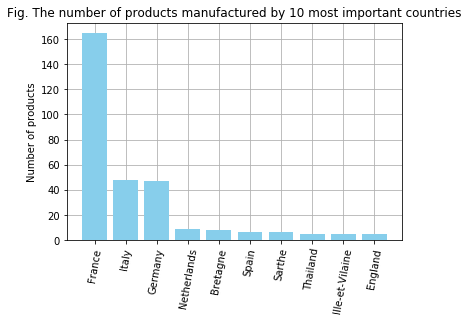

In [161]:
# Extract the 10 most important manufacturers countries and number of occurances.
manufacturer_countries = target_manufacturers.toPandas() 
manufacturer_countries = manufacturer_countries.head(10)

# Plot the number of products manufactured by 10 most important countries
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.bar(manufacturer_countries.manufacturing_places, manufacturer_countries.Count, zorder=3, color='skyblue')
plt.ylabel('Number of products')   
plt.xticks(manufacturer_countries.manufacturing_places, rotation='80')
plt.title('Fig. The number of products manufactured by 10 most important countries')
plt.show()

In [154]:
# Export manufacturing_places to CSV 
target_manufacturers.select("manufacturing_places").toPandas().to_csv('output/manufacturing_places.csv')

### Working with products' categories

In [12]:
extra_info_df = ' categories '
categories_df = spark.sql("SELECT" + p_id_col + extra_info_df + " FROM data_main")
categories_df.show(10)

+-------------+--------------------+----------+
|         code|        product_name|categories|
+-------------+--------------------+----------+
|0000000000017|    Vitória crackers|      null|
|0000000000031|               Cacao|      null|
|0000000000123|Sauce Sweety chil...|      null|
|0000000000291|           Mendiants|      null|
|0000000000949|Salade de carotte...|      null|
|0000000000970|Fromage blanc aux...|      null|
|0000000001001|                null|      null|
|0000000001007|            Vainilla|      null|
|0000000001137|   Baguette parisien|      null|
|0000000001151|&quot;Baguette Ly...|      null|
+-------------+--------------------+----------+
only showing top 10 rows



In [13]:
categories_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in traces_df.columns]).show()

+----+------------+----------+
|code|product_name|categories|
+----+------------+----------+
|   0|       25982|    514895|
+----+------------+----------+



In [14]:
non_swiss_sold.createOrReplaceTempView("target_products_df")
categories_df.createOrReplaceTempView("categories_df")
joined_df = spark.sql("SELECT p.code, c.categories, p.origins, p.manufacturing_places, p.countries  FROM target_products_df p INNER JOIN categories_df c ON p.code = c.code")


In [15]:
joined_df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in joined_df.columns]).show()

+----+----------+-------+--------------------+---------+
|code|categories|origins|manufacturing_places|countries|
+----+----------+-------+--------------------+---------+
|   0|        15|      0|                   0|        0|
+----+----------+-------+--------------------+---------+



In [16]:
joined_df.createOrReplaceTempView("target_products_cats")
sql_filter = "SELECT * FROM target_products_cats WHERE categories is not NULL"
target_products_categories_p = spark.sql(sql_filter)

print("Number of Products sold in Switzerland with categories:\n" + str(target_products_categories_p.count()))

Number of Products sold in Switzerland with categories:
358


In [17]:
target_products_categories_p.show(5)

+-------------+--------------------+--------------------+--------------------+--------------------+
|         code|          categories|             origins|manufacturing_places|           countries|
+-------------+--------------------+--------------------+--------------------+--------------------+
|4104420209114|Snacks sucrés,Bis...|Agriculture UE/No...|            Pays-Bas|    Allemagne,Suisse|
|7613331285263|    Nectar de fruits|Bulgarie,Roumanie...|           Allemagne|              Suisse|
|8076809513388|Epicerie,Sauces,S...|Italie,Tomates d'...|BARILLA ALIMENTAR...|Autriche,France,A...|
|9310055917996|Rice Crackers,Sna...|United States,Imp...|       United States|Australia, en:fra...|
|3256540011465|Snacks sucrés,Vie...|              France|              France|       France,Suisse|
+-------------+--------------------+--------------------+--------------------+--------------------+
only showing top 5 rows



In [44]:
# Flatten categories column
target_products_categories_p = target_products_categories_p.withColumn('categories', F.explode_outer(F.split('categories', ',')))

# Remove occurances of en: in name of categories
target_products_categories_p = target_products_categories_p.withColumn('categories', F.regexp_replace('categories', 'en:', ''))

target_products_categories_p.show(5)

+-------------+-------------------+--------------------+--------------------+----------------+
|         code|         categories|             origins|manufacturing_places|       countries|
+-------------+-------------------+--------------------+--------------------+----------------+
|4104420209114|      Snacks sucrés|Agriculture UE/No...|            Pays-Bas|Allemagne,Suisse|
|4104420209114|Biscuits et gâteaux|Agriculture UE/No...|            Pays-Bas|Allemagne,Suisse|
|4104420209114|        Pâtisseries|Agriculture UE/No...|            Pays-Bas|Allemagne,Suisse|
|4104420209114|            Gaufres|Agriculture UE/No...|            Pays-Bas|Allemagne,Suisse|
|7613331285263|   Nectar de fruits|Bulgarie,Roumanie...|           Allemagne|          Suisse|
+-------------+-------------------+--------------------+--------------------+----------------+
only showing top 5 rows



In [24]:
# Find dominant importers of ingredients
target_products_categories_p.createOrReplaceTempView("target_products_categories_p")
target_categories = spark.sql("SELECT categories, COUNT(categories) FROM target_products_categories_p GROUP BY categories ORDER BY COUNT(categories) DESC")
target_categories = target_categories.withColumnRenamed('count(categories)' , 'Count')
target_categories.show()

print("Number of Categories:\n" + str(target_categories.count()))

+--------------------+-----+
|          categories|Count|
+--------------------+-----+
|   Produits laitiers|   41|
|Aliments et boiss...|   40|
|Aliments d'origin...|   37|
|               Frais|   33|
|            Boissons|   31|
|            Fromages|   28|
|  Produits fermentés|   19|
|      Plats préparés|   18|
|Fromages pasteurisés|   17|
|   Fromages de vache|   16|
|Produits laitiers...|   16|
|Fromages industriels|   15|
|Boissons non sucrées|   15|
|  Fromages de France|   13|
|            Desserts|   13|
|Céréales et pomme...|   13|
|  Produits de la mer|   12|
|     Petit-déjeuners|   12|
|            Poissons|   11|
|       Snacks sucrés|   11|
+--------------------+-----+
only showing top 20 rows

Number of Categories:
831


In [25]:
# Export Categories to CSV 
target_categories.toPandas().to_csv('output/categories.csv')

In [31]:
target_categories.show()

+--------------------+-----+
|          categories|Count|
+--------------------+-----+
|   Produits laitiers|   41|
|Aliments et boiss...|   40|
|Aliments d'origin...|   37|
|               Frais|   33|
|            Boissons|   31|
|            Fromages|   28|
|  Produits fermentés|   19|
|      Plats préparés|   18|
|Fromages pasteurisés|   17|
|   Fromages de vache|   16|
|Produits laitiers...|   16|
|Fromages industriels|   15|
|Boissons non sucrées|   15|
|  Fromages de France|   13|
|            Desserts|   13|
|Céréales et pomme...|   13|
|  Produits de la mer|   12|
|     Petit-déjeuners|   12|
|            Poissons|   11|
|       Snacks sucrés|   11|
+--------------------+-----+
only showing top 20 rows



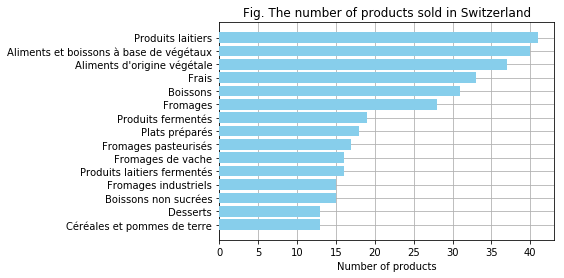

In [43]:
# Extract the 15 most frequent categories and number of occurances.
categories = target_categories.toPandas() 
categories = categories.head(15)

# Plot the most frequent categories
fig, ax = plt.subplots()
ax.grid(zorder=-1)
plt.barh(categories.categories, categories.Count, zorder=3, color='skyblue')
plt.xlabel('Number of products')   
plt.title('Fig. The number of products sold in Switzerland')
ax.invert_yaxis() 
plt.show()

In [81]:
# Extract the most important manufacturer countries for 15 most frequent categories

categories_countires_p = target_products_categories_p.withColumn('manufacturing_places', F.explode_outer(F.split('manufacturing_places', ',')))
products_cats_df = categories_countires_p.toPandas()

countries_cats = []
cat = "Snacks sucrés"
for index, row in categories.iterrows():
    temp_df = products_cats_df[(products_cats_df.categories == row.categories)].groupby('manufacturing_places').count().sort_values(by=['code'], ascending=False).head(5)
    countries_cats.append(temp_df)

# Each element of countries_cats is a dataframe containing the most important manufacturers
# of the corresponding category

i = 0
print("category: " + str(categories.iloc[i].categories))
print("The most important manufacturers:")
print(countries_cats[0].index.values)

category: Produits laitiers
The most important manufacturers:
['France' 'Italie' 'Pays de la Loire' 'Mayenne' 'Ille-et-Vilaine']


We will use extracted information about the most important manufacturer countries for 15 most frequent categories for our visualization.

## Descriptive Analysis

## Data Preprocessing